# Import Library yang Digunakan

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load kaggle api

In [ ]:
# Upload kaggle.json
from google.colab import files
files.upload()

In [36]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Data Understanding

In [37]:
!kaggle datasets download -d nicoletacilibiu/movies-and-ratings-for-recommendation-system -p /kaggle

Dataset URL: https://www.kaggle.com/datasets/nicoletacilibiu/movies-and-ratings-for-recommendation-system
License(s): CC0-1.0
movies-and-ratings-for-recommendation-system.zip: Skipping, found more recently modified local copy (use --force to force download)


unzip dataset

In [38]:
!unzip /kaggle/movies-and-ratings-for-recommendation-system.zip -d /kaggle

Archive:  /kaggle/movies-and-ratings-for-recommendation-system.zip
replace /kaggle/movies.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /kaggle/movies.csv      
replace /kaggle/ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /kaggle/ratings.csv     


konversi data movies ke dalam dataframe

In [143]:
movies_df = pd.read_csv('/kaggle/movies.csv', on_bad_lines='skip')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


konversi data ratings ke dalam dataframe

In [144]:
ratings_df = pd.read_csv('/kaggle/ratings.csv', on_bad_lines='skip')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


cek variabel

In [145]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


insight :
- terdapat 9742 baris data di dalam dataset
- data terdiri dari 3 kolom yaitu : movieId, title, dan genres.
- terdapat 1 data bertipe int64 yaitu kolom movieId, dan 2 kolom bertipe object yaitu kolom title dan genres

In [146]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


insight :
- terdapat 100836 baris data di dalam dataset
- data terdiri dari 4 kolom yaitu : userId,movieId, rating, dan timestamp.
- terdapat 3 data bertipe int64 yaitu kolom user_id dan movieId, dan 1 kolom bertipe float64 yaitu kolom rating

In [147]:
# cek jumlah data
print('Jumlah data movies: ',len(movies_df.movieId.unique()))
print('Jumlah data user: ',len(ratings_df.userId.unique()))

Jumlah data movies:  9742
Jumlah data user:  610


berdasarkan data understanding yang telah dilakukan, data ratings_df tidak diperlukan untuk membuat content based filtering recommender system

# Univariate Exploratory Data Analysis

## Memeriksa Missing Value

In [148]:
missing_values_movie = movies_df.isnull().sum()
print('jumlah missing value pada data movie: ', missing_values_movie)

missing_values_rating = ratings_df.isnull().sum()
print('jumlah missing value pada data rating: ', missing_values_rating)

jumlah missing value pada data movie:  movieId    0
title      0
genres     0
dtype: int64
jumlah missing value pada data rating:  userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


insight :
- tidak ditemukan missing value di dalam data

## Memeriksa Outlier

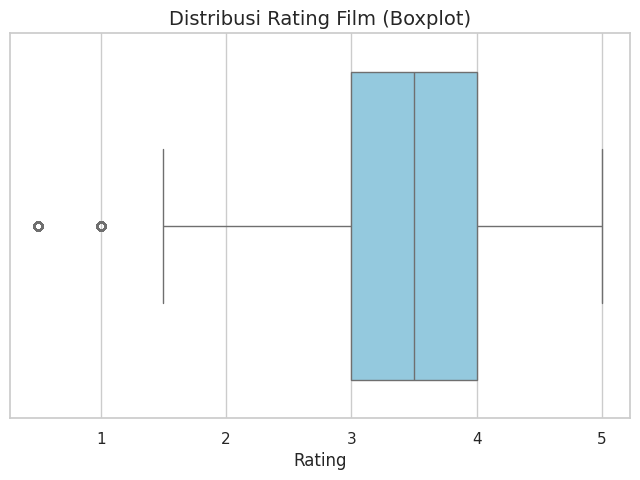

In [149]:
sns.set(style="whitegrid")

# Buat figure boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x=ratings_df['rating'], color='skyblue')

# Judul dan label
plt.title('Distribusi Rating Film (Boxplot)', fontsize=14)
plt.xlabel('Rating')

# Tampilkan plot
plt.show()

insight :  
- tidak ditemukan outlier di dalam data

## Memeriksa data duplikat

In [150]:
# jumlah data duplikat pada data movie
jumlah_duplikat_movie = movies_df.duplicated().sum()
print('Jumlah data duplikat pada data movie: ', jumlah_duplikat_movie)

# jumlah data duplikat pada data rating
jumlah_duplikat_rating = ratings_df.duplicated().sum()
print('Jumlah data duplikat pada data rating', jumlah_duplikat_rating)

Jumlah data duplikat pada data movie:  0
Jumlah data duplikat pada data rating 0


insight :
- tidak ditemukan data duplikat

## Univariate Analysis

In [151]:
# cek daftar genre
all_genres = movies_df['genres'].str.split('|').explode()

unique_genres = all_genres.unique()
print('Jumlah genre unik:', len(unique_genres))
print('Daftar genre unik:')
for genre in unique_genres:
    print('-', genre)

Jumlah genre unik: 20
Daftar genre unik:
- Adventure
- Animation
- Children
- Comedy
- Fantasy
- Romance
- Drama
- Action
- Crime
- Thriller
- Horror
- Mystery
- Sci-Fi
- War
- Musical
- Documentary
- IMAX
- Western
- Film-Noir
- (no genres listed)


cek jumlah setiap genre

Genre terbanyak:

genres
Drama                 4361
Comedy                3756
Thriller              1894
Action                1828
Romance               1596
Adventure             1263
Crime                 1199
Sci-Fi                 980
Horror                 978
Fantasy                779
Children               664
Animation              611
Mystery                573
Documentary            440
War                    382
Musical                334
Western                167
IMAX                   158
Film-Noir               87
(no genres listed)      34
Name: count, dtype: int64


<ipython-input-152-2f9d20bda529>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')


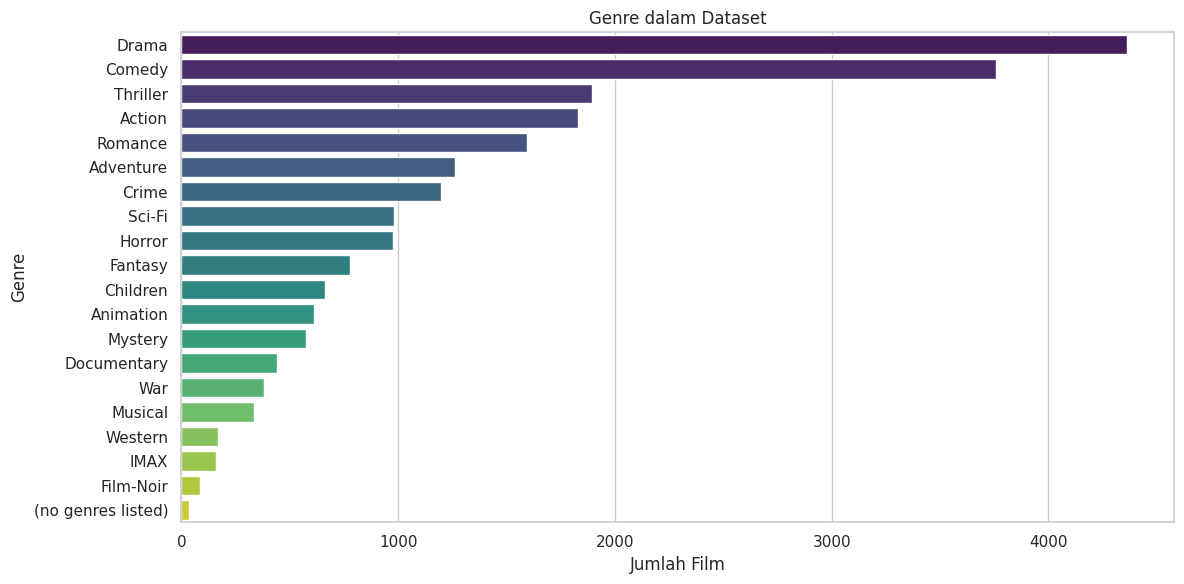

In [152]:
# Visualisasi jumlah genre
genre_counts = all_genres.value_counts()

# Tampilkan  genre terbanyak
print("Genre terbanyak:\n")
print(genre_counts)
# Visualisasi dengan barplot
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')

plt.title('Genre dalam Dataset')
plt.xlabel('Jumlah Film')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

insight :
- terdapat 20 genre unik di dalam dataset.
- Drama adalah genre yang paling banyak muncul, diikuti oleh Comedy dan Thriller.
- Genre seperti Film-Noir dan Western tergolong langka.
- Terdapat 34 film tanpa genre yang tercantum, sehingga perlu dilakukan penghapusan karena model content based filtering yang akan dibangun berdasarkan genre.

# Data Preprocessing

## Data movie

In [153]:
# Hapus baris yang kolom 'genres' berisi '(no genres listed)'
fix_movie = movies_df[movies_df['genres'] != '(no genres listed)'].copy()

# Cek hasil
print(f"Sebelum: {len(movies_df)} baris")
print(f"Setelah: {len(fix_movie)} baris")


Sebelum: 9742 baris
Setelah: 9708 baris


konversi data ke dalam list

In [154]:
# mengonversi setiap data series 'movieId' menjadi bentuk list
moviesId = fix_movie['movieId'].tolist()

# mengonversi data 'title' menjadi bentuk list
title = fix_movie['title'].tolist()

# mengonversi data 'genres' menjadi bentuk list
genres = fix_movie['genres'].tolist()

print(len(moviesId))
print(len(title))
print(len(genres))

9708
9708
9708


Membuat dictionary untuk data ‘moviesId’, ‘title’, dan ‘genres’

In [155]:
movies_new = pd.DataFrame({
    'moviesId': moviesId,
    'title': title,
    'genres': genres
})
movies_new

,moviesId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9703,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9704,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9705,193585,Flint (2017),Drama
9706,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


# Model Deployment

In [156]:
# membuat salinan dari data movies
data_movies = fix_movie.copy()

### TF_IDF Vectorizer

In [157]:
# Inisialisasi TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')

tfidf_matrix = tfidf.fit_transform(data_movies['genres'])

tfidf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'horror', 'imax',
       'musical', 'mystery', 'noir', 'romance', 'sci', 'thriller', 'war',
       'western'], dtype=object)

insight
- Mengubah teks genre menjadi vektor numerik untuk mengubah setiap kumpulan genre (contohnya "Action|Adventure|Fantasy") menjadi vektor berdasarkan bobot TF-IDF (Term Frequency-Inverse Document Frequency).

menampilkan dimensi (ukuran) dari matriks TF-IDF

In [158]:
tfidf_matrix.shape

(9708, 21)

Mengubah matrix TF-IDF dari format sparse menjadi format dense agar dapat diproses atau ditampilkan secara lengkap.

In [159]:
tfidf_matrix.todense()

matrix([[0.        , 0.4168036 , 0.51628768, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.51229321, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.5784593 , 0.        , 0.81571125, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

memvisualisasikan sebagian data TF-IDF hasil ekstraksi

In [160]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names_out(),
    index=data_movies['title']
).sample(20, axis=1).sample(10, axis=0)

,musical,film,sci,animation,comedy,fantasy,romance,western,noir,documentary,action,children,war,horror,drama,mystery,crime,thriller,fi,adventure
title,,,,,,,,,,,,,,,,,,,,
"Night in the Life of Jimmy Reardon, A (1988)",0.0,0.0,0.000000,0.000000,0.570705,0.000000,0.821155,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
Vampire Hunter D: Bloodlust (Banpaia hantâ D) (2000),0.0,0.0,0.428253,0.489629,0.000000,0.458077,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.428518,0.000000,0.000000,0.0,0.0,0.428253,0.000000
Sliver (1993),0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000
Duel in the Sun (1946),0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.463136,0.834962,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.297228,0.000000,0.0,0.0,0.000000,0.000000
"Big Country, The (1958)",0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.485057,0.874482,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
"Help, The (2011)",0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000
"Goonies, The (1985)",0.0,0.0,0.000000,0.000000,0.287084,0.518597,0.000000,0.000000,0.0,0.0,0.393093,0.542086,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.447505
Junior (1994),0.0,0.0,0.652242,0.000000,0.386212,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.652242,0.000000
Practical Magic (1998),0.0,0.0,0.000000,0.000000,0.000000,0.570036,0.454040,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.291390,0.619676,0.0,0.0,0.000000,0.000000


menggunakan subset 1000 film pertama untuk menghemat ram

In [168]:
tfidf_sample = tfidf_matrix[:1000]
cosine_sim_sample = cosine_similarity(tfidf_sample)
cosine_sim_sample

array([[1.        , 0.8136036 , 0.15259961, ..., 0.        , 0.19644499,
        0.        ],
       [0.8136036 , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15259961, 0.        , 1.        , ..., 0.        , 0.41928688,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.2655035 ,
        0.14113079],
       [0.19644499, 0.        , 0.41928688, ..., 0.2655035 , 1.        ,
        0.24464599],
       [0.        , 0.        , 0.        , ..., 0.14113079, 0.24464599,
        1.        ]])

insight

- Menghitung similarity antar film berdasarkan fitur TF-IDF dari deskripsi atau metadata film.

- Mengurangi penggunaan memori dan mempercepat perhitungan dengan membatasi data hanya pada 1000 film pertama, karena menghitung similarity untuk seluruh dataset bisa sangat berat dan lambat jika dataset besar.

membuat DataFrame dari hasil perhitungan cosine similarity antar film

In [162]:
cosine_sim_df = pd.DataFrame(
    cosine_sim_sample,
    index=data_movies['title'][:1000],
    columns=data_movies['title'][:1000]
)

print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (1000, 1000)


title,In the Name of the Father (1993),Blue in the Face (1995),"Cowboy Way, The (1994)",I Like It Like That (1994),S.F.W. (1994)
title,,,,,
"Flower of My Secret, The (La flor de mi secreto) (1995)",0.678412,1.000000,0.704998,0.687217,0.678412
Halloween: The Curse of Michael Myers (Halloween 6: The Curse of Michael Myers) (1995),0.000000,0.000000,0.000000,0.000000,0.000000
Angels and Insects (1995),0.540111,0.366418,0.258324,0.863186,0.540111
Nell (1994),1.000000,0.678412,0.478279,0.466216,1.000000
"Thin Blue Line, The (1988)",0.000000,0.000000,0.000000,0.000000,0.000000
"Day the Earth Stood Still, The (1951)",0.318942,0.216374,0.152543,0.148696,0.318942
Twister (1996),0.000000,0.000000,0.339112,0.365008,0.000000
Addams Family Values (1993),0.000000,0.262576,0.185116,0.180447,0.000000
M. Butterfly (1993),0.540111,0.366418,0.258324,0.863186,0.540111


membangun model content based filtering

In [163]:
def movie_recommendations(title, similarity_data=cosine_sim_df, items=data_movies[['title', 'genres']], k=5):
    if title not in similarity_data.columns:
        return f"Film '{title}' tidak ditemukan dalam data."

    index = similarity_data.loc[:, title].to_numpy().argpartition(range(-1, -k, -1))
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(title, errors='ignore')
    return pd.DataFrame({'title': closest}).merge(items, on='title').head(k)


cek salah satu judul filem untuk di tes

In [164]:
data_movies[data_movies.title.eq('Jumanji (1995)')]

,movieId,title,genres
1,2,Jumanji (1995),Adventure|Children|Fantasy


mencoba melihat rekomendasi berdasarkan film 'Jumanji (1995)'

In [165]:
movie_recommendations('Jumanji (1995)')

,title,genres
0,"NeverEnding Story III, The (1994)",Adventure|Children|Fantasy
1,"Indian in the Cupboard, The (1995)",Adventure|Children|Fantasy
2,Escape to Witch Mountain (1975),Adventure|Children|Fantasy
3,"Kid in King Arthur's Court, A (1995)",Adventure|Children|Comedy|Fantasy|Romance
4,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


# Evauation

** Precision**
**Precision** adalah matriks evaluasi kinerja model sistem rekomendasi yang mengukur seberapa banyak rekomendasi yang diberikan oleh sistem benar-benar relevan atau sesuai dengan preferensi pengguna. Secara matematis :

$$
\text{Precision} = \frac{\text{Jumlah item relevan yang direkomendasikan}}{\text{Jumlah total item yang direkomendasikan}}
$$

#### Alasan Memilih Precision sebagai Metrik Evaluasi

1. Fokus pada kualitas rekomendasi yang diberikan

   Precision menilai seberapa tepat rekomendasi yang muncul. Dalam konteks content-based filtering, rekomendasi yang akurat sangat penting agar pengguna merasa puas dan sistem dianggap bermanfaat.

2. Mudah dipahami dan diinterpretasikan

   Precision memberikan gambaran langsung berapa banyak rekomendasi yang benar-benar relevan dibanding total rekomendasi yang diberikan. Nilai precision yang tinggi menunjukkan kualitas rekomendasi yang baik.

3. Relevan untuk kasus rekomendasi dengan daftar terbatas

   Dalam banyak kasus, sistem rekomendasi hanya menampilkan sejumlah kecil item (misal top 5 atau top 10). Precision cocok digunakan untuk menilai performa dalam skala kecil tersebut.

4. Tidak bergantung pada total jumlah item relevan di database

   Berbeda dengan recall yang membutuhkan data lengkap tentang semua item relevan, precision hanya fokus pada hasil rekomendasi yang muncul. Ini memudahkan evaluasi terutama ketika data lengkap sulit diketahui.

#### Kesimpulan

Precision adalah metrik yang tepat digunakan untuk mengevaluasi sistem rekomendasi content-based filtering karena memberikan informasi jelas tentang proporsi rekomendasi yang benar-benar relevan bagi pengguna. Dengan memaksimalkan precision, kita dapat meningkatkan kepuasan pengguna terhadap rekomendasi yang diberikan.

---


In [166]:
# Fungsi cek relevansi berdasarkan kesamaan genre
def is_relevant(genre_str, target_genres):
    genres = set(genre_str.split('|'))
    return target_genres.issubset(genres)

# Fungsi utama: hitung precision berdasarkan judul film
def evaluate_precision_by_title(movie_title):
    # cari genre dari film input
    movie_row = data_movies[data_movies['title'] == movie_title]

    if movie_row.empty:
        print(f"Film '{movie_title}' tidak ditemukan.")
        return

    target_genres = set(movie_row.iloc[0]['genres'].split('|'))

    # ambil rekomendasi
    recommendations = movie_recommendations(movie_title)

    # hitung precision
    total_recs = len(recommendations)
    relevant_recs = recommendations['genres'].apply(lambda x: is_relevant(x, target_genres)).sum()
    precision = relevant_recs / total_recs if total_recs > 0 else 0

    print(f"Precision untuk film '{movie_title}' dengan target genre {target_genres}: {precision:.2f}")


In [167]:
evaluate_precision_by_title('Jumanji (1995)')

Precision untuk film 'Jumanji (1995)' dengan target genre {'Fantasy', 'Children', 'Adventure'}: 1.00


insight :
- sistem rekomendasi dengan collaborative filtering mencapai metric evaluasi precision sebesar 100%  